### Importation / Configuration

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from utils.confusion_matrix import confusion_matrix
import warnings

In [2]:
starbucks = pd.read_csv("clean_starbucks.csv")

In [3]:
z = starbucks.Category

starbucks.drop(columns=["Category", "size", "product_name"], axis=1, inplace=True)


In [4]:
z.unique()

array(['coffee', 'tea', 'other', 'chocolate', 'frappuccino'], dtype=object)

### Entrainement et prédiction

Recherche des paramètres optimaux

In [5]:
param_grid = {'solver': ["lbgs","newton-cg", "sag"], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }


In [20]:
X_train, X_test, z_train, z_test = train_test_split(starbucks, z, test_size=0.33, random_state=40)

cls = LogisticRegression(C=1000,solver="newton-cg")
#search = GridSearchCV(cls, param_grid, scoring="accuracy", cv=10) on trouve C=1000 et solver = newton-cg
#print(search.best_params_)


cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
print(max(cross_val_score(cls, starbucks, z, cv=cv)))

warnings.filterwarnings('ignore')

cls.fit(X_train, z_train)

z_pred = cls.predict(X_test)

y_pred = cross_val_predict(cls, starbucks, z, cv=5)

print(accuracy_score(z_pred, z_test))
print(accuracy_score(y_pred, z))



0.9246376811594202
0.9102902374670184
0.7890148212728858


### Matrice de confusion

In [21]:
confusion_df = confusion_matrix(z_test, z_pred)
confusion_df

Prédiction,chocolate,coffee,frappuccino,other,tea
Réalité,,,,,
chocolate,96.153846,0.000000,0.000000,0.000000,3.846154
coffee,0.628931,90.566038,5.031447,1.257862,2.515723
frappuccino,0.000000,6.542056,91.588785,0.934579,0.934579
other,15.384615,0.000000,0.000000,61.538462,23.076923
tea,0.000000,5.405405,0.000000,0.000000,94.594595


<Axes: xlabel='Prédiction', ylabel='Réalité'>

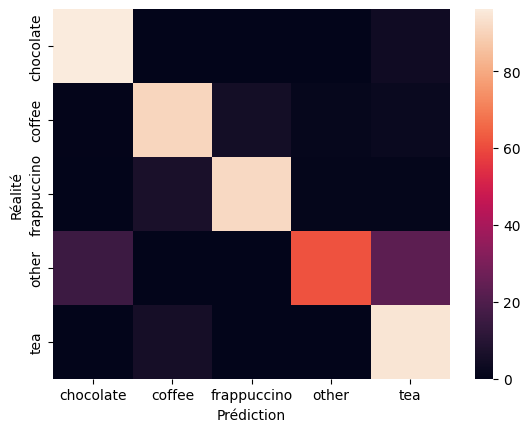

In [22]:
sns.heatmap(confusion_df)

### Significativité des coefficients

#### Importance moyenne dans toutes les classes

<Axes: ylabel='Feature'>

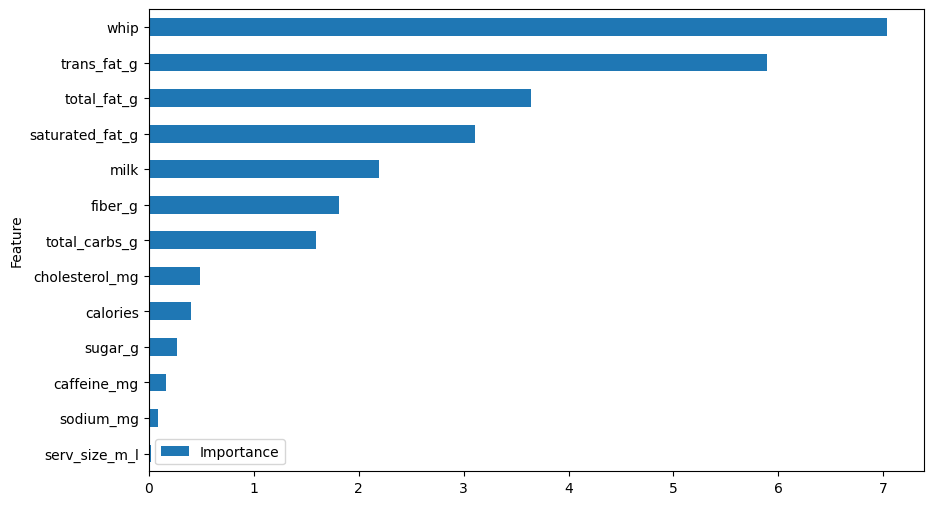

In [23]:
coefficients = cls.coef_

avg_importance = np.mean(np.abs(coefficients), axis=0)
feature_importancedf = pd.DataFrame({'Feature': starbucks.columns, 'Importance': avg_importance})
feature_importancedf = feature_importancedf.sort_values('Importance', ascending=True)
feature_importancedf.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [24]:
def feature_importance(cls, class_label):
    class_index = np.where(cls.classes_ == class_label)[0][0]

    feature_importance = pd.DataFrame({'Feature': starbucks.columns, 'Importance': cls.coef_[class_index]})
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

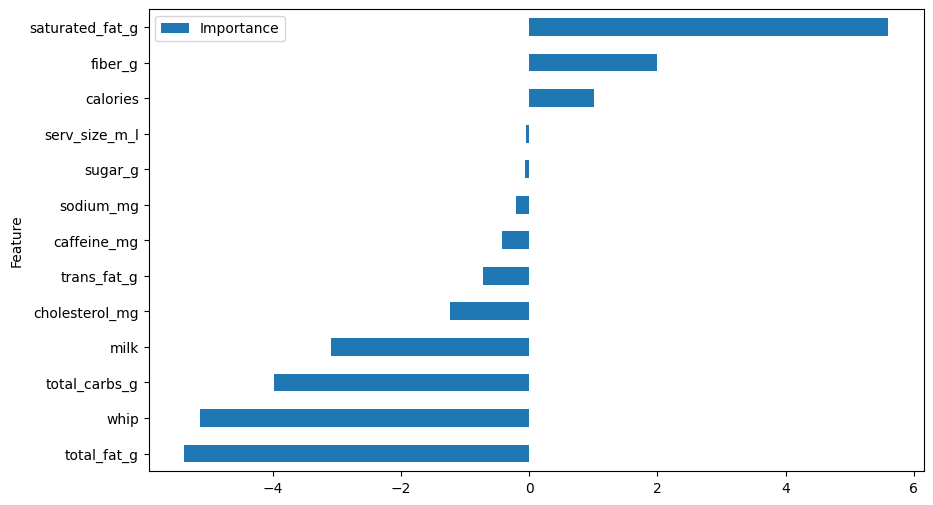

In [25]:
feature_importance(cls, "chocolate")

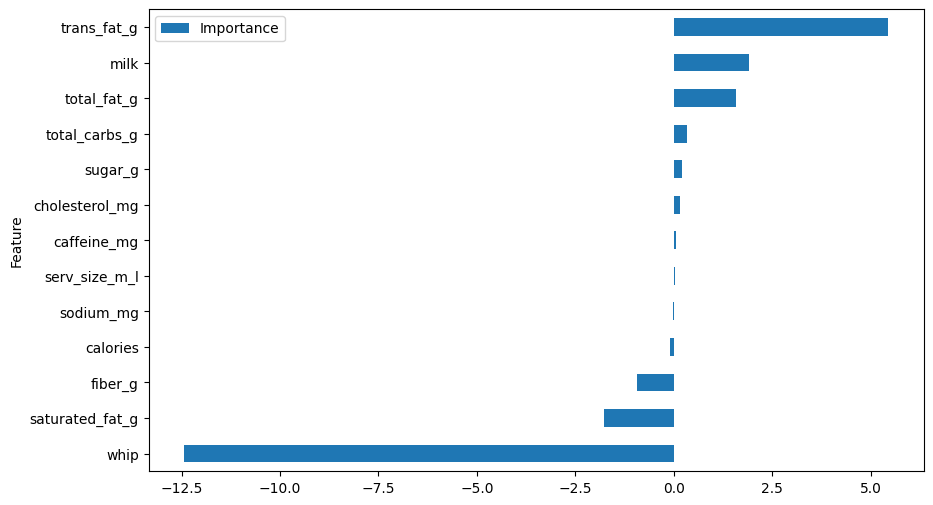

In [26]:
feature_importance(cls, "tea")

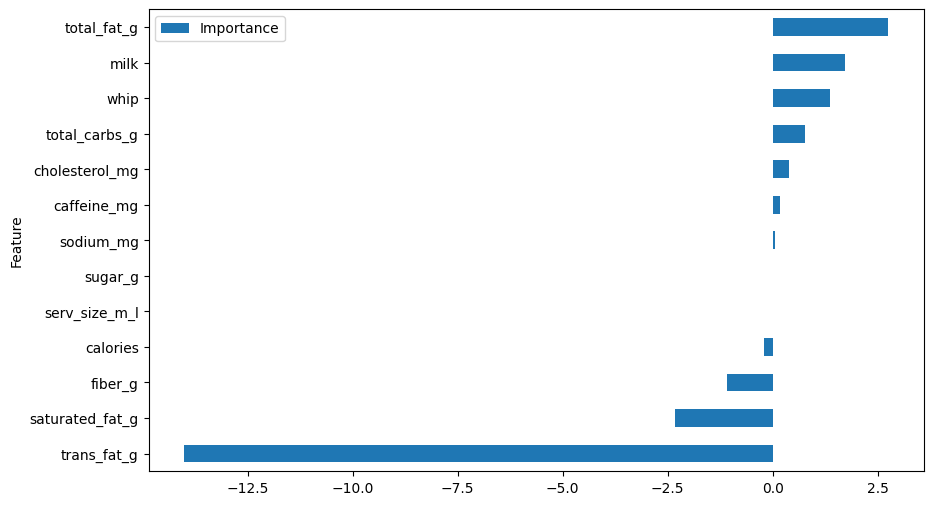

In [27]:
feature_importance(cls, "coffee")

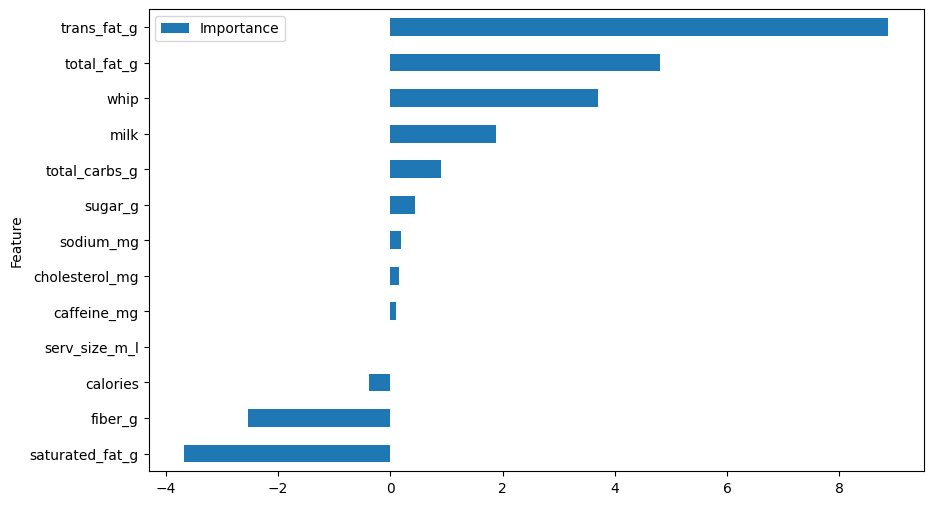

In [28]:
feature_importance(cls, "frappuccino")

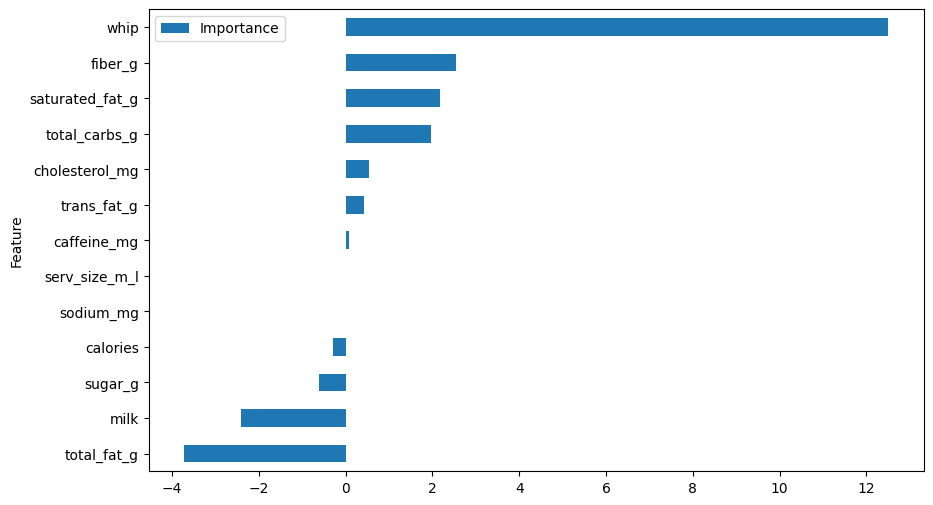

In [29]:
feature_importance(cls, "other")

### Test en enlevent les variables peu importantes

On prend en critère importance moyenne < 0.2

In [30]:
feat_to_drop = feature_importancedf.loc[feature_importancedf.Importance < 0.2, 'Feature']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(starbucks.drop(columns=feat_to_drop, axis=1), z, test_size=0.33)

lr_d = LogisticRegression(max_iter=9999999999)
lr_d.fit(X_train, y_train)

y_pred = lr_d.predict(X_test)

accuracy_score(y_pred, y_test)

0.6675461741424802

#### On passe de 91% de précision à 64% -> mauvaise idée

### Avec caractéristiques centrées réduites

Selon cet [article](https://quantifyinghealth.com/standardized-vs-unstandardized-regression-coefficients/), centrer et réduire les caractéristiques est plus pertinant lorsqu'il y en a plus que deux

In [37]:
scaler = StandardScaler()
scaler.fit(starbucks)

scaled_starbucks = scaler.transform(starbucks)

cls = LogisticRegression(C=1000,solver="newton-cg")

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
print(max(cross_val_score(cls, starbucks, z, cv=cv)))

cls

0.9246376811594202


Conclusion: on obtient le même score que sans scale
Cause : cela vient sûrement du fait que les données ne suivent pas une loi normale de base